# Connect with G Drive to import data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Organising the data in train & val folders

In [2]:
import os
import shutil
import random

base_dir = "/content/drive/MyDrive/dataset"
train_dir = os.path.join(base_dir, "train")
val_dir   = os.path.join(base_dir, "val")

split_ratio = 0.8
random.seed(42)


In [3]:
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)


In [4]:
classes = [
    d for d in os.listdir(base_dir)
    if os.path.isdir(os.path.join(base_dir, d))
    and d not in ["train", "val"]
]

for cls in classes:
    cls_path = os.path.join(base_dir, cls)
    images = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]

    random.shuffle(images)
    split_idx = int(len(images) * split_ratio)

    train_images = images[:split_idx]
    val_images   = images[split_idx:]

    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)

    for img in train_images:
        src = os.path.join(cls_path, img)
        dst = os.path.join(train_dir, cls, img)
        if not os.path.exists(dst):
            shutil.copy2(src, dst)

    for img in val_images:
        src = os.path.join(cls_path, img)
        dst = os.path.join(val_dir, cls, img)
        if not os.path.exists(dst):
            shutil.copy2(src, dst)

print("✅ Dataset split completed safely.")


✅ Dataset split completed safely.


# Importing Libraries

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from torchvision import models

In [12]:
train_path = "/content/drive/MyDrive/dataset/train"
val_path   = "/content/drive/MyDrive/dataset/val"

# Transformations for train & val data

In [14]:
train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])



test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Creating custom dataset

In [ ]:
class Car_Dataset(Dataset):
  def __init__(self, dir_path, transform=None):
    self.data = ImageFolder(dir_path, transform=transform)

  def __len__(self):
    return len(self.data)

  def __getitem__(self, index):
    return self.data[index]

In [ ]:
train_set = Car_Dataset(dir_path=train_path, transform=train_transforms)
test_set  = Car_Dataset(dir_path=val_path, transform=test_transforms)

# Distribution of the data

In [17]:
print(f"Size of training dataset: {len(train_set)}")
print(f"Size of testing dataset: {len(test_set)}")

Size of training dataset: 1840
Size of testing dataset: 460


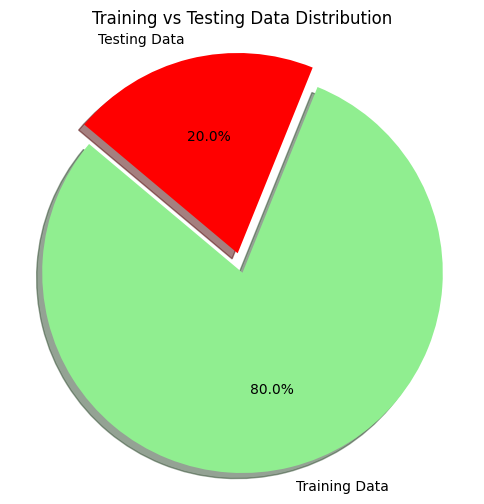

In [18]:
labels = ['Training Data', 'Testing Data']
sizes  = [len(train_set), len(test_set)]
colors = ['lightgreen', 'red']
explode = (0.1, 0)
plt.figure(figsize=(6, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors,
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.title('Training vs Testing Data Distribution')
plt.axis('equal')
plt.show()

In [19]:
train_set.data.classes

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [26]:
train_set.data.class_to_idx

{'F_Breakage': 0,
 'F_Crushed': 1,
 'F_Normal': 2,
 'R_Breakage': 3,
 'R_Crushed': 4,
 'R_Normal': 5}

In [24]:
for image, label in train_set:
  print(image, label)
  break

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

# Data loader

In [27]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=2)
eval_loader = DataLoader(test_set, batch_size=64, num_workers=2)

# Starting with a custom cnn model

In [ ]:
class Car_Classifier_CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.pool = nn.AdaptiveAvgPool2d((1,1))

        self.classifier = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

# Setting up the device to free google colab gpu

In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:

custom_cnn = Car_Classifier_CNN(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.Adam(custom_cnn.parameters(), lr=0.001, weight_decay=1e-4)

# Training the model

In [31]:
epochs = 30
train_losses = []

for epoch in range(epochs):
  custom_cnn.train()
  running_loss = 0
  total        = 0
  correct      = 0

  for images, labels in tqdm(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = custom_cnn(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    total += len(labels)

    _, preds = torch.max(outputs, dim=1)
    correct += (preds == labels).sum().item()

  accuracy = (correct / total)
  train_loss = running_loss / len(train_loader)
  train_losses.append(train_loss)
  print(f"Epoch : {epoch + 1}, Training Loss : {train_loss},  Accuracy : {accuracy:.2f}%")

100%|██████████| 29/29 [03:50<00:00,  7.94s/it]


Epoch : 1, Training Loss : 1.6773786544799805,  Accuracy : 0.32%


100%|██████████| 29/29 [00:29<00:00,  1.01s/it]


Epoch : 2, Training Loss : 1.522877676733609,  Accuracy : 0.42%


100%|██████████| 29/29 [00:28<00:00,  1.03it/s]


Epoch : 3, Training Loss : 1.39374067865569,  Accuracy : 0.47%


100%|██████████| 29/29 [00:32<00:00,  1.13s/it]


Epoch : 4, Training Loss : 1.2739563687094326,  Accuracy : 0.52%


100%|██████████| 29/29 [00:28<00:00,  1.02it/s]


Epoch : 5, Training Loss : 1.2465400243627613,  Accuracy : 0.52%


100%|██████████| 29/29 [00:28<00:00,  1.03it/s]


Epoch : 6, Training Loss : 1.2165370234127701,  Accuracy : 0.55%


100%|██████████| 29/29 [00:27<00:00,  1.05it/s]


Epoch : 7, Training Loss : 1.2077229721792813,  Accuracy : 0.56%


100%|██████████| 29/29 [00:28<00:00,  1.00it/s]


Epoch : 8, Training Loss : 1.1977782085024078,  Accuracy : 0.55%


100%|██████████| 29/29 [00:28<00:00,  1.03it/s]


Epoch : 9, Training Loss : 1.184841669839004,  Accuracy : 0.56%


100%|██████████| 29/29 [00:28<00:00,  1.02it/s]


Epoch : 10, Training Loss : 1.1678476374724815,  Accuracy : 0.58%


100%|██████████| 29/29 [00:28<00:00,  1.01it/s]


Epoch : 11, Training Loss : 1.156721328866893,  Accuracy : 0.58%


100%|██████████| 29/29 [00:28<00:00,  1.01it/s]


Epoch : 12, Training Loss : 1.146267582630289,  Accuracy : 0.59%


100%|██████████| 29/29 [00:28<00:00,  1.01it/s]


Epoch : 13, Training Loss : 1.1427013257454182,  Accuracy : 0.59%


100%|██████████| 29/29 [00:28<00:00,  1.01it/s]


Epoch : 14, Training Loss : 1.1299961147637203,  Accuracy : 0.59%


100%|██████████| 29/29 [00:28<00:00,  1.01it/s]


Epoch : 15, Training Loss : 1.1179325087317105,  Accuracy : 0.59%


100%|██████████| 29/29 [00:28<00:00,  1.01it/s]


Epoch : 16, Training Loss : 1.114530057742678,  Accuracy : 0.61%


100%|██████████| 29/29 [00:28<00:00,  1.01it/s]


Epoch : 17, Training Loss : 1.1143714210082745,  Accuracy : 0.61%


100%|██████████| 29/29 [00:28<00:00,  1.01it/s]


Epoch : 18, Training Loss : 1.1033041579969998,  Accuracy : 0.62%


100%|██████████| 29/29 [00:28<00:00,  1.02it/s]


Epoch : 19, Training Loss : 1.0992365705555882,  Accuracy : 0.62%


100%|██████████| 29/29 [00:28<00:00,  1.01it/s]


Epoch : 20, Training Loss : 1.0829598657016097,  Accuracy : 0.63%


100%|██████████| 29/29 [00:28<00:00,  1.01it/s]


Epoch : 21, Training Loss : 1.112258689156894,  Accuracy : 0.61%


100%|██████████| 29/29 [00:28<00:00,  1.01it/s]


Epoch : 22, Training Loss : 1.0960757033578281,  Accuracy : 0.62%


100%|██████████| 29/29 [00:28<00:00,  1.01it/s]


Epoch : 23, Training Loss : 1.0821778198768353,  Accuracy : 0.62%


100%|██████████| 29/29 [00:28<00:00,  1.03it/s]


Epoch : 24, Training Loss : 1.0711393829049736,  Accuracy : 0.64%


100%|██████████| 29/29 [00:28<00:00,  1.03it/s]


Epoch : 25, Training Loss : 1.062860877349459,  Accuracy : 0.64%


100%|██████████| 29/29 [00:27<00:00,  1.04it/s]


Epoch : 26, Training Loss : 1.0556538207777615,  Accuracy : 0.65%


100%|██████████| 29/29 [00:27<00:00,  1.04it/s]


Epoch : 27, Training Loss : 1.0603940836314498,  Accuracy : 0.64%


100%|██████████| 29/29 [00:28<00:00,  1.02it/s]


Epoch : 28, Training Loss : 1.0447164588961109,  Accuracy : 0.65%


100%|██████████| 29/29 [00:27<00:00,  1.04it/s]


Epoch : 29, Training Loss : 1.0437344230454544,  Accuracy : 0.65%


100%|██████████| 29/29 [00:28<00:00,  1.02it/s]

Epoch : 30, Training Loss : 1.0371732567918712,  Accuracy : 0.67%


# Evaluating the model

In [32]:
custom_cnn.eval()
total = 0
correct = 0
accuracies = []
all_preds = []
all_labels = []

with torch.no_grad():
  for images, labels in tqdm(eval_loader):
    images = images.to(device)
    labels = labels.to(device)

    outputs = custom_cnn(images)
    _, preds = torch.max(outputs, dim=1)

    total += len(labels)
    correct += (preds == labels).sum().item()
    accuracies.append(correct/total)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

val_accuracy = (correct / total)
print(f"Evaluation Accuracy : {val_accuracy:.4f}%")

100%|██████████| 8/8 [01:05<00:00,  8.18s/it]

Evaluation Accuracy : 0.4826%


# Plotting the progress

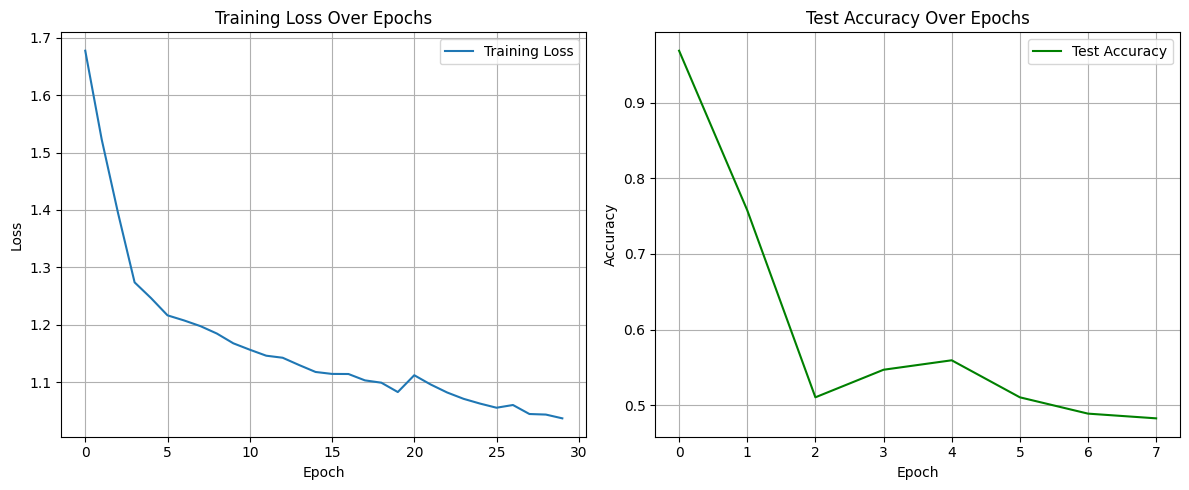

In [33]:
plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Over Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Evaluatig the model performence

In [35]:
class_names = eval_loader.dataset.data.classes
print(classification_report(all_labels, all_preds, target_names=class_names))

              precision    recall  f1-score   support

  F_Breakage       0.39      0.97      0.56       100
   F_Crushed       0.50      0.01      0.02        80
    F_Normal       0.82      0.53      0.64       100
  R_Breakage       0.40      0.70      0.51        60
   R_Crushed       0.50      0.07      0.12        60
    R_Normal       0.83      0.42      0.56        60

    accuracy                           0.48       460
   macro avg       0.57      0.45      0.40       460
weighted avg       0.57      0.48      0.42       460



# Plotting the Confussion Metrix

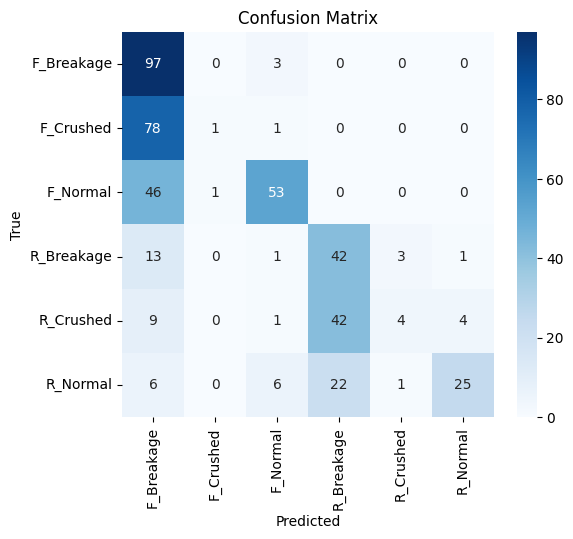

In [36]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Transfer Learning with Resnet 18

In [ ]:

class Car_Classifier_Resnet(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.model = models.resnet18(weights="DEFAULT")

        for param in self.model.parameters():
            param.requires_grad = False

        for param in self.model.layer4.parameters():
            param.requires_grad = True

        for module in self.model.modules():
            if isinstance(module, nn.BatchNorm2d):
                for param in module.parameters():
                    param.requires_grad = True

        self.model.fc = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(self.model.fc.in_features, num_classes)
        )


    def forward(self, x):
        return self.model(x)

In [ ]:
resnet_18 = Car_Classifier_Resnet(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(resnet_18.parameters(), lr=0.002, weight_decay=1e-4)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 106MB/s]


# Training the model

In [42]:
epochs = 15
train_losses = []

for epoch in range(epochs):
  resnet_18.train()
  running_loss = 0
  total        = 0
  correct      = 0

  for images, labels in tqdm(train_loader):
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = resnet_18(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    total += len(labels)

    _, preds = torch.max(outputs, dim=1)
    correct += (preds == labels).sum().item()

  accuracy = (correct / total)
  train_loss = running_loss / len(train_loader)
  train_losses.append(train_loss)
  print(f"Epoch : {epoch + 1}, Training Loss : {train_loss},  Accuracy : {accuracy:.2f}%")

100%|██████████| 29/29 [00:28<00:00,  1.01it/s]


Epoch : 1, Training Loss : 0.5576681299456234,  Accuracy : 0.95%


100%|██████████| 29/29 [00:28<00:00,  1.00it/s]


Epoch : 2, Training Loss : 0.5408628634337721,  Accuracy : 0.96%


100%|██████████| 29/29 [00:28<00:00,  1.03it/s]


Epoch : 3, Training Loss : 0.5170059234931551,  Accuracy : 0.97%


100%|██████████| 29/29 [00:28<00:00,  1.01it/s]


Epoch : 4, Training Loss : 0.5159030001738976,  Accuracy : 0.97%


100%|██████████| 29/29 [00:28<00:00,  1.03it/s]


Epoch : 5, Training Loss : 0.5073884818060644,  Accuracy : 0.97%


100%|██████████| 29/29 [00:28<00:00,  1.01it/s]


Epoch : 6, Training Loss : 0.48816245794296265,  Accuracy : 0.98%


100%|██████████| 29/29 [00:28<00:00,  1.01it/s]


Epoch : 7, Training Loss : 0.49175768165752803,  Accuracy : 0.98%


100%|██████████| 29/29 [00:28<00:00,  1.02it/s]


Epoch : 8, Training Loss : 0.489152239314441,  Accuracy : 0.98%


100%|██████████| 29/29 [00:28<00:00,  1.03it/s]


Epoch : 9, Training Loss : 0.4910891816533845,  Accuracy : 0.98%


100%|██████████| 29/29 [00:28<00:00,  1.01it/s]


Epoch : 10, Training Loss : 0.48319293301680993,  Accuracy : 0.98%


100%|██████████| 29/29 [00:28<00:00,  1.02it/s]


Epoch : 11, Training Loss : 0.46835673163677083,  Accuracy : 0.99%


100%|██████████| 29/29 [00:28<00:00,  1.02it/s]


Epoch : 12, Training Loss : 0.4842422676497492,  Accuracy : 0.98%


100%|██████████| 29/29 [00:28<00:00,  1.01it/s]


Epoch : 13, Training Loss : 0.4725079947504504,  Accuracy : 0.99%


100%|██████████| 29/29 [00:28<00:00,  1.03it/s]


Epoch : 14, Training Loss : 0.47634168842743185,  Accuracy : 0.98%


100%|██████████| 29/29 [00:28<00:00,  1.02it/s]

Epoch : 15, Training Loss : 0.4648646794516465,  Accuracy : 0.99%


# Evaluating the model

In [45]:

resnet_18.eval()
total = 0
correct = 0
accuracies = []
all_preds = []
all_labels = []

with torch.no_grad():
  for images, labels in tqdm(eval_loader):
    images = images.to(device)
    labels = labels.to(device)

    outputs = resnet_18(images)
    _, preds = torch.max(outputs, dim=1)

    total += len(labels)
    correct += (preds == labels).sum().item()
    accuracies.append(correct/total)

    all_preds.extend(preds.cpu().numpy())
    all_labels.extend(labels.cpu().numpy())

val_accuracy = (correct / total)
print(f"Evaluation Accuracy : {val_accuracy:.4f}%")

100%|██████████| 8/8 [00:06<00:00,  1.29it/s]

Evaluation Accuracy : 0.7391%


# Plotting the progress

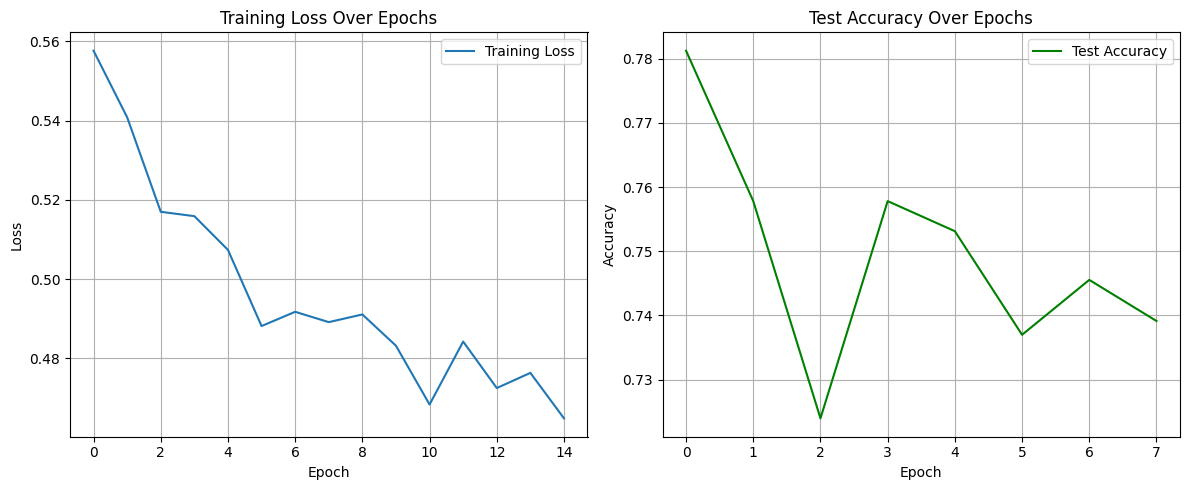

In [46]:

plt.figure(figsize=(12, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(accuracies, label='Test Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Test Accuracy Over Epochs')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

# Classification Report

In [47]:

class_names = eval_loader.dataset.data.classes
print(classification_report(all_labels, all_preds, target_names=class_names))

              precision    recall  f1-score   support

  F_Breakage       0.78      0.80      0.79       100
   F_Crushed       0.65      0.65      0.65        80
    F_Normal       0.82      0.81      0.81       100
  R_Breakage       0.89      0.65      0.75        60
   R_Crushed       0.59      0.75      0.66        60
    R_Normal       0.74      0.72      0.73        60

    accuracy                           0.74       460
   macro avg       0.74      0.73      0.73       460
weighted avg       0.75      0.74      0.74       460



# Confussion Metrix

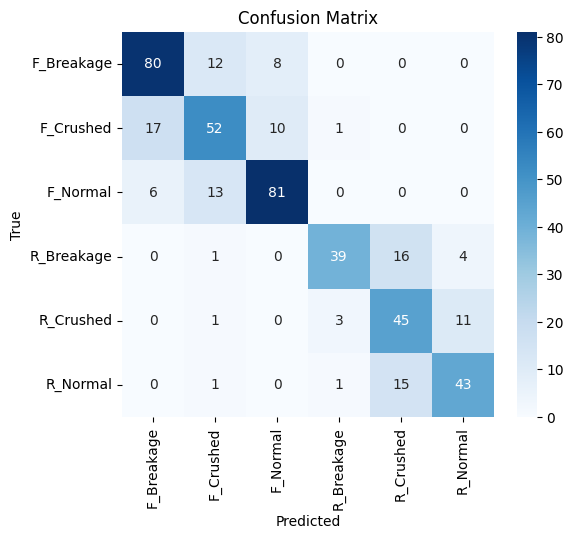

In [48]:

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

# Saving the resnet model

In [50]:

torch.save(resnet_18.state_dict(), "Damage_Classifier_Resnet_18.pth")

# Conclusion

1. The custom model was seems to be under fitting underfitting

2. The resnet model was giving slightly better result's even though i did not get very good eval score but it's still okay